<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Gen%20AI%20Foundational%20Models%20for%20NLP%20%26%20Language%20Understanding/Integrating_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Integrating Word2Vec**
---


## Setup


In [ ]:
!mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
!pip install gensim #4.2.0
!pip install portalocker>=2.0.0

In [ ]:
!pip install -Uq torchtext==0.15.1
!pip install -Uq torch==2.0.0
!pip install -Uq torchdata==0.6.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from IPython.core.display import display, SVG

from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset

import logging
from gensim.models import Word2Vec
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe,vocab
from torchdata.datapipes.iter import IterableWrapper, Mapper
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm

%matplotlib inline

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# Function to plot word embeddings in a 2d space
def plot_embeddings(word_embeddings,vocab=vocab):

    tsne = TSNE(n_components=2, random_state=0)
    word_embeddings_2d = tsne.fit_transform(word_embeddings)

    # Plotting the results with labels from vocab
    plt.figure(figsize=(15, 15))
    for i, word in enumerate(vocab.get_itos() ):  # assuming vocab.itos gives the list of words in your vocab
        plt.scatter(word_embeddings_2d[i, 0], word_embeddings_2d[i, 1])
        plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]))

    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.title("Word Embeddings visualized with t-SNE")
    plt.show()

In [3]:
# This function returns the most similar words to a target word by calculating word vectors' cosine distance
def find_similar_words(word, word_embeddings, top_k=5):
    if word not in word_embeddings:
        print("Word not found in embeddings.")
        return []

    # Get the embedding for the given word
    target_embedding = word_embeddings[word]

    # Calculate cosine similarities between the target word and all other words
    similarities = {}
    for w, embedding in word_embeddings.items():
        if w != word:
            similarity = torch.dot(target_embedding, embedding) / (
                torch.norm(target_embedding) * torch.norm(embedding)
            )
            similarities[w] = similarity.item()

    # Sort the similarities in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Return the top k similar words
    most_similar_words = [w for w, _ in sorted_similarities[:top_k]]
    return most_similar_words

In [4]:
#  Function that trains word2vec model on toy data
def train_model(model, dataloader, criterion, optimizer, num_epochs=1000):
    """
    Train the model for the specified number of epochs.

    Args:
        model: The PyTorch model to be trained.
        dataloader: DataLoader providing data for training.
        criterion: Loss function.
        optimizer: Optimizer for updating model's weights.
        num_epochs: Number of epochs to train the model for.

    Returns:
        model: The trained model.
        epoch_losses: List of average losses for each epoch.
    """

    # List to store running loss for each epoch
    epoch_losses = []

    for epoch in tqdm(range(num_epochs)):
        # Storing running loss values for the current epoch
        running_loss = 0.0

        # Using tqdm for a progress bar
        for idx, samples in enumerate(dataloader):

            optimizer.zero_grad()

            # Check for EmbeddingBag layer in the model
            if any(isinstance(module, nn.EmbeddingBag) for _, module in model.named_modules()):
                target, context, offsets = samples
                predicted = model(context, offsets)

            # Check for Embedding layer in the model
            elif any(isinstance(module, nn.Embedding) for _, module in model.named_modules()):
                target, context = samples
                predicted = model(context)

            loss = criterion(predicted, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            running_loss += loss.item()

        # Append average loss for the epoch
        epoch_losses.append(running_loss / len(dataloader))

    return model, epoch_losses

# Background

## Word2Vec

Word2Vec is a family of  methods that transforms words into number vectors, positioning similar words close together in a space defined by these numbers. This way, you can quantify and analyze word relationships mathematically. For instance, words like "cat" and "kitten" or "cat" and "dog" have vectors that are close to each other, while a word like "book" is positioned further away in this vector space.


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Words.png" alt="Word2Vec example" class="bg-primary" width="400px">



## GloVe

Unlike word2vec, which is based on predicting context/target words, GloVe focuses on capturing the global word co-occurrence statistics from the entire corpus. It constructs a co-occurrence matrix that represents how often words appear together in the text. The matrix is then factorized to obtain the word embeddings.

To accomplish this, you can usually begin by initializing WF (Word-Feature matrix) and FC (Feature-Context matrix) with random weights.You will then perform a multiplication operation between these matrices to obtain WC' (an approximation of WC), and assess its similarity to WC. This process is repeated multiple times using Stochastic Gradient Descent (SGD) to minimize the error(WC'-WC).

Once the training is complete, the resulting Word-Feature matrix (WF) provides you with word embeddings or vector representations for each word(the green vector in the diagram). The dimensionality of the embedding vectors can be predetermined by setting the value of F to a specific number of dimensions, allowing for a compact representation of the word semantics.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/matrix%20fact.png" alt="Co-occurence matrix" class="bg-primary" width="600px">

The key advantage of GloVe is that it can incorporate both global statistics and local context information. This results in word embeddings that not only capture the semantic relationships between words but also preserve certain syntactic relationships.


# Create and Train Word2Vec Models

In [5]:
toy_data = """I wish I was little bit taller
I wish I was a baller
She wore a small black dress to the party
The dog chased a big red ball in the park
He had a huge smile on his face when he won the race
The tiny kitten played with a fluffy toy mouse
The team celebrated their victory with a grand parade
She bought a small, delicate necklace for her sister
The mountain peak stood majestic and tall against the clear blue sky
The toddler took small, careful steps as she learned to walk
The house had a spacious backyard with a big swimming pool
He felt a sense of accomplishment after completing the challenging puzzle
The chef prepared a delicious, flavorful dish using fresh ingredients
The children played happily in the small, cozy room
The book had an enormous impact on readers around the world
The wind blew gently, rustling the leaves of the tall trees
She painted a beautiful, intricate design on the small canvas
The concert hall was filled with thousands of excited fans
The garden was adorned with colorful flowers of all sizes
I hope to achieve great success in my chosen career path
The skyscraper towered above the city, casting a long shadow
He gazed in awe at the breathtaking view from the mountaintop
The artist created a stunning masterpiece with bold brushstrokes
The baby took her first steps, a small milestone that brought joy to her parents
The team put in a tremendous amount of effort to win the championship
The sun set behind the horizon, painting the sky in vibrant colors
The professor gave a fascinating lecture on the history of ancient civilizations
The house was filled with laughter and the sound of children playing
She received a warm, enthusiastic welcome from the audience
The marathon runner had incredible endurance and determination
The child's eyes sparkled with excitement upon opening the gift
The ship sailed across the vast ocean, guided by the stars
The company achieved remarkable growth in a short period of time
The team worked together harmoniously to complete the project
The puppy wagged its tail, expressing its happiness and affection
She wore a stunning gown that made her feel like a princess
The building had a grand entrance with towering columns
The concert was a roaring success, with the crowd cheering and clapping
The baby took a tiny bite of the sweet, juicy fruit
The athlete broke a new record, achieving a significant milestone in her career
The sculpture was a masterpiece of intricate details and craftsmanship
The forest was filled with towering trees, creating a sense of serenity
The children built a small sandcastle on the beach, their imaginations running wild
The mountain range stretched as far as the eye could see, majestic and awe-inspiring
The artist's brush glided smoothly across the canvas, creating a beautiful painting
She received a small token of appreciation for her hard work and dedication
The orchestra played a magnificent symphony that moved the audience to tears
The flower bloomed in vibrant colors, attracting butterflies and bees
The team celebrated their victory with a big, extravagant party
The child's laughter echoed through the small room, filling it with joy
The sunflower stood tall, reaching for the sky with its bright yellow petals
The city skyline was dominated by tall buildings and skyscrapers
The cake was adorned with a beautiful, elaborate design for the special occasion
The storm brought heavy rain and strong winds, causing widespread damage
The small boat sailed peacefully on the calm, glassy lake
The artist used bold strokes of color to create a striking and vivid painting
The couple shared a passionate kiss under the starry night sky
The mountain climber reached the summit after a long and arduous journey
The child's eyes widened in amazement as the magician performed his tricks
The garden was filled with the sweet fragrance of blooming flowers
The basketball player made a big jump and scored a spectacular slam dunk
The cat pounced on a small mouse, displaying its hunting instincts
The mansion had a grand entrance with a sweeping staircase and chandeliers
The raindrops fell gently, creating a rhythmic patter on the roof
The baby took a big step forward, encouraged by her parents' applause
The actor delivered a powerful and emotional performance on stage
The butterfly fluttered its delicate wings, mesmerizing those who watched
The company launched a small-scale advertising campaign to test the market
The building was constructed with strong, sturdy materials to withstand earthquakes
The singer's voice was powerful and resonated throughout the concert hall
The child built a massive sandcastle with towers, moats, and bridges
The garden was teeming with a variety of small insects and buzzing bees
The athlete's muscles were well-developed and strong from years of training
The sun cast long shadows as it set behind the mountains
The couple exchanged heartfelt vows in a beautiful, intimate ceremony
The dog wagged its tail vigorously, a sign of excitement and happiness
The baby let out a tiny giggle, bringing joy to everyone around"""


In [9]:
# Get tokenizer
tokenizer = get_tokenizer('basic_english')

# Tokenize sentences
def tokenize_data(sentences):
    for sentence in sentences:
        yield tokenizer(sentence)

# Tokenize Data
tokenized_toy_data = tokenizer(toy_data)

# Create vocab
vocab = build_vocab_from_iterator(tokenize_data(tokenized_toy_data), specials=['<unk>'])
vocab.set_default_index(vocab["<unk>"])

# Example
sample_sentence = "I wish I was a baller"
tokenized_sample = tokenizer(sample_sentence)
encoded_sample = [vocab[token] for token in tokenized_sample]
print("Encoded sample:", encoded_sample)

Encoded sample: [20, 108, 20, 7, 2, 133]


In [10]:
# Pipeline for Numericalization of tokens
text_pipeline = lambda tokens:[ vocab[token]  for token in tokens]

## Continuous Bag of Words (CBOW)
---

For the Continuous Bag of Words (CBOW) model, use a "context" to predict a target word. The "context" is typically a set of surrounding words. For example, if your context window is of size 2, then you take two words before and two words after the target word as context.

You can slide over the sequence and create training data:


In [12]:
CONTEXT_SIZE=2

cobow_data = []
for i in range(1, len(tokenized_toy_data) - CONTEXT_SIZE):
    context = (
        [tokenized_toy_data [i - j - 1] for j in range(CONTEXT_SIZE)]
        + [tokenized_toy_data [i + j + 1] for j in range(CONTEXT_SIZE)]
    )
    target = tokenized_toy_data [i]
    cobow_data.append((context, target))

print(cobow_data[1]) # I wish "I" was little
print(cobow_data[2]) # wish I "was" little bit

(['wish', 'i', 'was', 'little'], 'i')
(['i', 'wish', 'little', 'bit'], 'was')


You would want to find the emeddings that guide the model to predict the following probilaties. $P(w_t| w_{t-2},w_{t-1},w_{t+1},w_{t+2})$ is the probability of $w_t$, the target word, conditioned on the occurrence of context words $w_{t-2},w_{t-1},w_{t+1},w_{t+2}$.


In [13]:
def collate_batch(batch):
    target_list, context_list, offsets = [], [], [0]
    for _context, _target in batch:
        target_list.append(vocab[_target])
        processed_context = torch.tensor(text_pipeline(_context), dtype=torch.int64)
        context_list.append(processed_context)
        offsets.append(processed_context.size(0))
    target_list = torch.tensor(target_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    context_list = torch.cat(context_list)
    return target_list.to(device), context_list.to(device), offsets.to(device)

In [15]:
target_list, context_list, offsets = collate_batch(cobow_data[0:10])
print(f"target_list(Tokenized target words): {target_list} , context_list(Surrounding context words): {context_list} , offsets(Starting indexes of context words for each target): {offsets} ")

target_list(Tokenized target words): tensor([108,  20,   7, 272, 136, 376,  20, 108,  20,   7]) , context_list(Surrounding context words): tensor([ 20,  51,  20,   7, 108,  20,   7, 272,  20, 108, 272, 136,   7,  20,
        136, 376, 272,   7, 376,  20, 136, 272,  20, 108, 376, 136, 108,  20,
         20, 376,  20,   7, 108,  20,   7,   2,  20, 108,   2, 133]) , offsets(Starting indexes of context words for each target): tensor([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36]) 


In [16]:
BATCH_SIZE = 64  # batch size for training

# DataLoader Object
dataloader_cbow = DataLoader(
    cobow_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
print(dataloader_cbow)

In [18]:
class CBOW(nn.Module):
    # Initialize the CBOW model
    def __init__(self, vocab_size, embed_dim, num_class):
        super(CBOW, self).__init__()
        # Define the embedding layer using nn.EmbeddingBag
        # It outputs the average of context words embeddings
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        # Define the first linear layer with input size embed_dim and output size embed_dim//2
        self.linear1 = nn.Linear(embed_dim, embed_dim//2)
        # Define the fully connected layer with input size embed_dim//2 and output size vocab_size
        self.fc = nn.Linear(embed_dim//2, vocab_size)
        self.init_weights()

    # Initialize the weights of the model's parameters
    def init_weights(self):
        # Initialize the weights of the embedding layer
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # Initialize the weights of the fully connected layer
        self.fc.weight.data.uniform_(-initrange, initrange)
        # Initialize the biases of the fully connected layer to zeros
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        # Pass the input text and offsets through the embedding layer
        out = self.embedding(text, offsets)
        # Apply the ReLU activation function to the output of the first linear layer
        out = torch.relu(self.linear1(out))
        # Pass the output of the ReLU activation through the fully connected layer
        return self.fc(out)

vocab_size = len(vocab)
emsize = 24
model_cbow = CBOW(vocab_size, emsize, vocab_size).to(device)


LR = 5  # learning rate

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cbow.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

model_cbow, epoch_losses=train_model(model_cbow, dataloader_cbow, criterion, optimizer, num_epochs=400)

100%|██████████| 400/400 [00:17<00:00, 22.70it/s]


Text(0, 0.5, 'Loss')

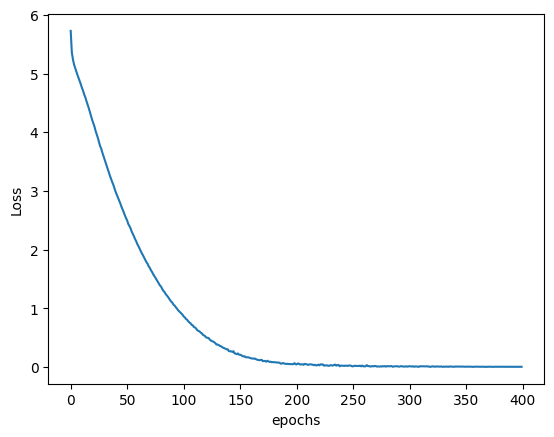

In [20]:
plt.plot(epoch_losses)
plt.xlabel("epochs")
plt.ylabel("Loss")

In [21]:
# The model's weights are the actual word embeddings
word_embeddings = model_cbow.embedding.weight.detach().cpu().numpy()
word = 'baller'
word_index = vocab.get_stoi()[word] # getting the index of the word in the vocab
print(word_embeddings[word_index])

[ 0.20150457 -0.29977676 -1.5110143   0.66205096  0.38215032  0.137927
  1.3989943   0.28181356  0.34231055  0.8570202  -0.15111992 -0.65017164
  0.19005205  0.9795727  -0.5931466  -0.55427796  0.28550252 -0.73624617
  0.8868592   0.4632508   0.10018994  0.96380544  0.07371426  0.21953854]


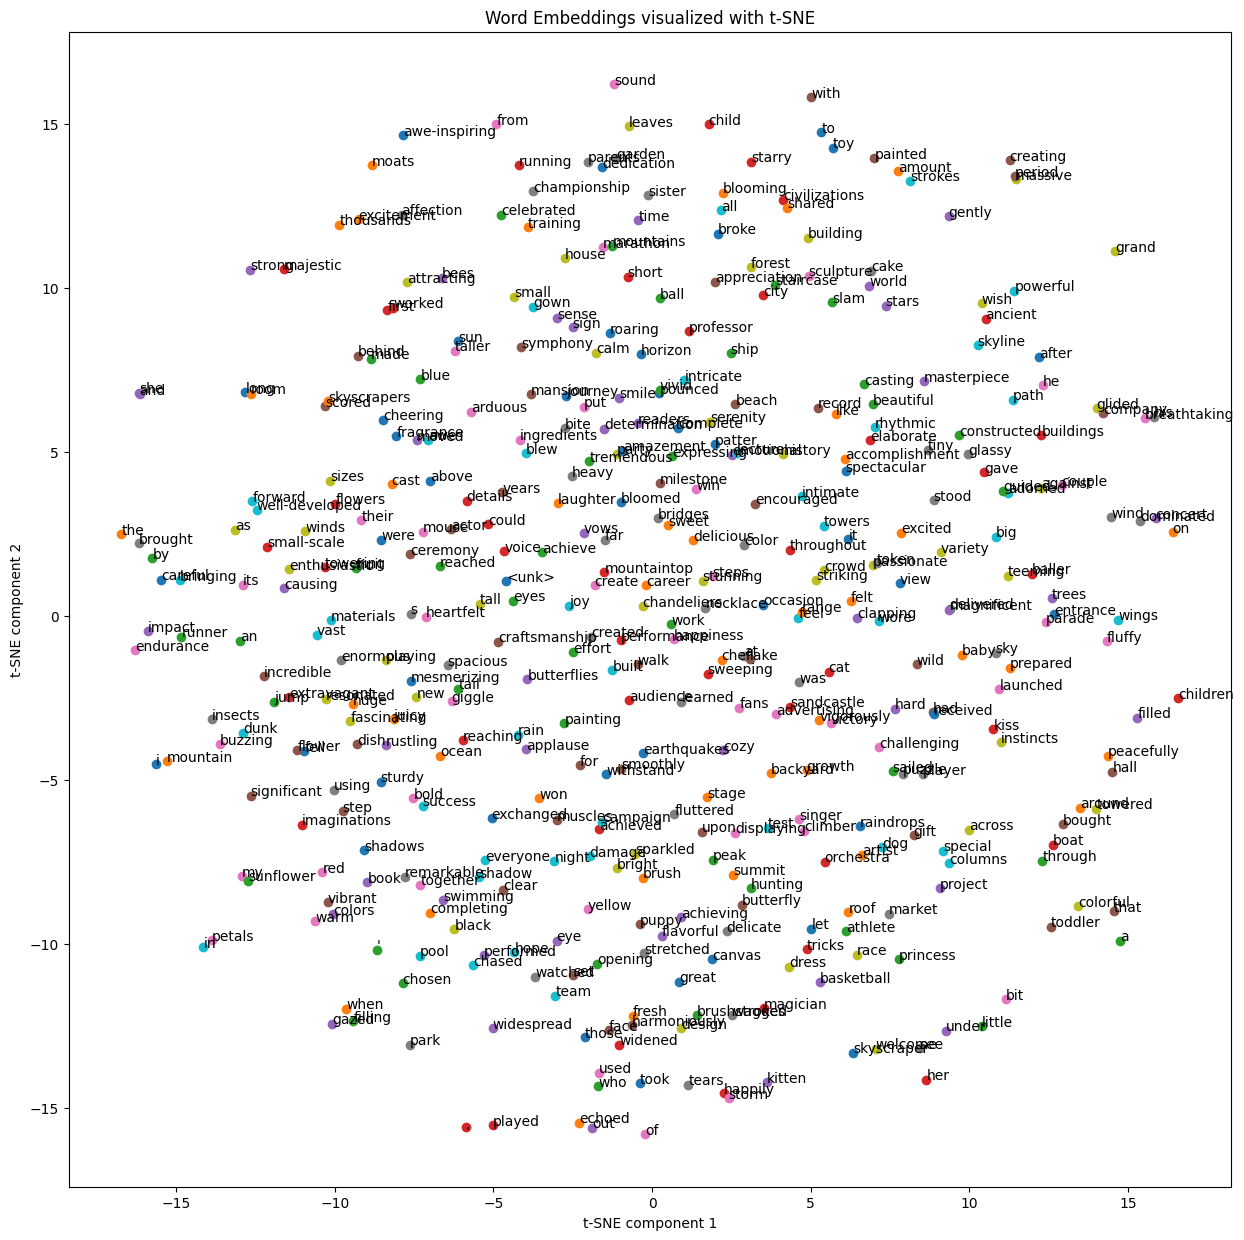

In [22]:
# Check if embeddings represent similarities among words
plot_embeddings(word_embeddings,vocab=vocab)

## Skip-gram model
---

In the Skip-gram model, the goal is to predict the surrounding words (context) given a central word (target). The main idea behind this model is that words that appear in similar contexts tend to have similar meanings.

The Skip-gram model aims to understand word relationships by predicting the context from a given target word.



In contrast to the standard notation in conditional probability, where the dependent variable is typically represented as the target, the current terminology reverses this convention.


In [25]:
# Define the window size for the context around the target word.
CONTEXT_SIZE = 2

# Initialize an empty list to store the (target, context) pairs.
skip_data = []

# Iterate over each word in the tokenized toy_data, while excluding the first and last few words determined by the CONTEXT_SIZE.
for i in range(CONTEXT_SIZE, len(tokenized_toy_data) - CONTEXT_SIZE):

    # For a word at position i, the context comprises of words from the preceding CONTEXT_SIZE as well as from the succeeding CONTEXT_SIZE. The context words are collected in a list.
    context = (
        [tokenized_toy_data[i - j - 1] for j in range(CONTEXT_SIZE)]  # Preceding words
        + [tokenized_toy_data[i + j + 1] for j in range(CONTEXT_SIZE)]  # Succeeding words
    )

    # The word at the current position i is taken as the target.
    target = tokenized_toy_data[i]

    # Append the (target, context) pair to the skip_data list.
    skip_data.append((target, context))

skip_data[0]

('i', ['wish', 'i', 'was', 'little'])

In [24]:
skip_data_ = [[(sample[0], word) for word in sample[1]] for sample in skip_data]

In [28]:
skip_data_flat= [item  for items in  skip_data_ for item in items]
skip_data_flat[0:12]

[('i', 'wish'),
 ('i', 'i'),
 ('i', 'was'),
 ('i', 'little'),
 ('was', 'i'),
 ('was', 'wish'),
 ('was', 'little'),
 ('was', 'bit'),
 ('little', 'was'),
 ('little', 'i'),
 ('little', 'bit'),
 ('little', 'taller')]

In [29]:
def collate_fn(batch):
    target_list, context_list = [], []
    for _context, _target in batch:

        target_list.append(vocab[_target])
        context_list.append(vocab[_context])

    target_list = torch.tensor(target_list, dtype=torch.int64)
    context_list = torch.tensor(context_list, dtype=torch.int64)
    return target_list.to(device), context_list.to(device)

In [30]:
dataloader = DataLoader(skip_data_flat, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [31]:
next(iter(dataloader))

(tensor([108,  20,   7, 272,  20, 108, 272, 136,   7,  20, 136, 376, 272,   7,
         376,  20, 136, 272,  20, 108, 376, 136, 108,  20,  20, 376,  20,   7,
         108,  20,   7,   2,  20, 108,   2, 133,   7,  20, 133,  14,   2,   7,
          14, 109, 133,   2, 109,   2,  14, 133,   2,   8, 109,  14,   8, 138,
           2, 109, 138, 198,   8,   2, 198,  10]),
 tensor([ 20,  20,  20,  20,   7,   7,   7,   7, 272, 272, 272, 272, 136, 136,
         136, 136, 376, 376, 376, 376,  20,  20,  20,  20, 108, 108, 108, 108,
          20,  20,  20,  20,   7,   7,   7,   7,   2,   2,   2,   2, 133, 133,
         133, 133,  14,  14,  14,  14, 109, 109, 109, 109,   2,   2,   2,   2,
           8,   8,   8,   8, 138, 138, 138, 138]))

In [32]:
class SkipGram_Model(nn.Module):

    def __init__(self, vocab_size, embed_dim):
        super(SkipGram_Model, self).__init__()
        # Define the embeddings layer
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        # Define the fully connected layer
        self.fc = nn.Linear(in_features=embed_dim, out_features=vocab_size)

    def forward(self, text):
        # Perform the forward pass
        # Pass the input text through the embeddings layer
        out = self.embeddings(text)
        # Pass the output of the embeddings layer through the fully connected layer
        # Apply the ReLU activation function
        out = torch.relu(out)
        out = self.fc(out)
        return out

In [33]:
emsize = 24
model_sg = SkipGram_Model(vocab_size, emsize).to(device)

LR = 5  # learning rate
#BATCH_SIZE = 64  # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sg.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

model_sg, epoch_losses=train_model(model_sg, dataloader, criterion, optimizer, num_epochs=400)

100%|██████████| 400/400 [00:35<00:00, 11.34it/s]


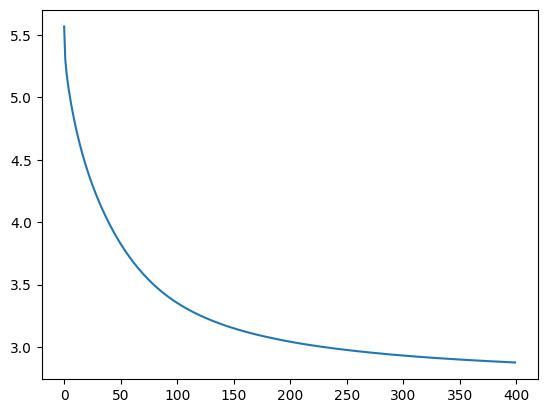

In [34]:
plt.plot(epoch_losses)

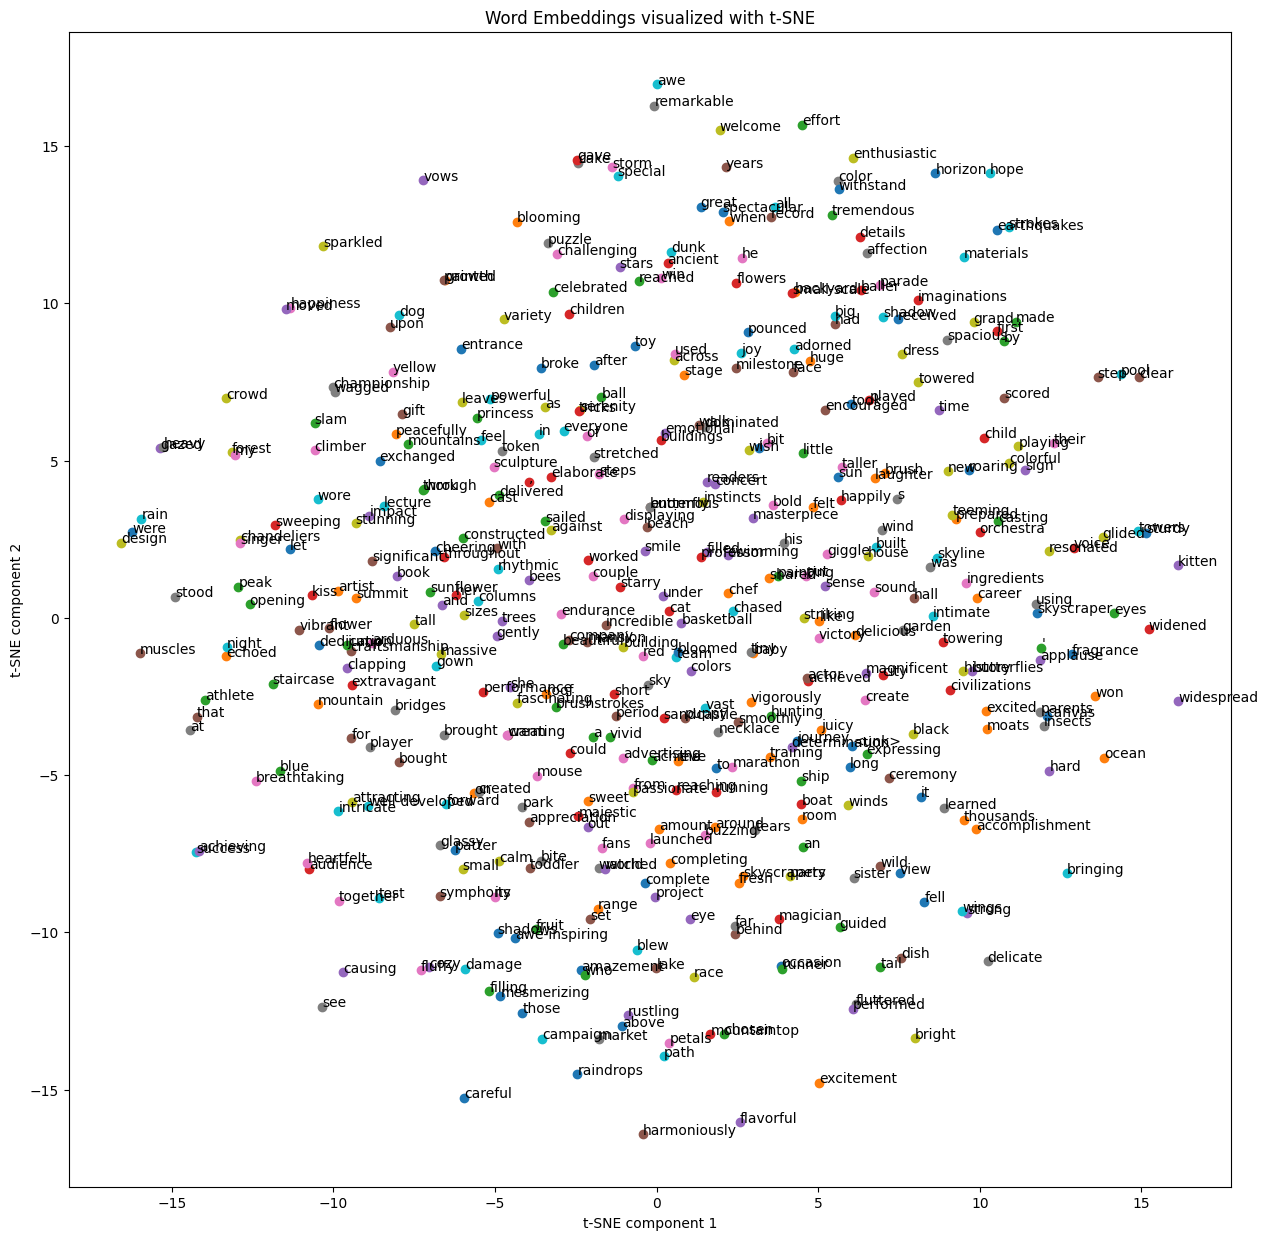

In [35]:
word_embeddings = model_sg.embeddings.weight.detach().cpu().numpy()
plot_embeddings(word_embeddings,vocab=vocab)


When selecting CBOW or Skip-Gram, the best approach often depends on the specifics of your task and data. If your dataset is small but you need to have a good representation of rarer words, Skip-gram might be the better choice. If the computational efficiency is more critical and the rare words are less of a concern, CBOW might be adequate. It's also worth noting that for very small datasets, the benefits of neural word embeddings might be limited, and simpler methods or leveraging pretrained embeddings might be more effective.



# Applying Pretrained Word Embeddings
## Load Stanford GloVe model



In [36]:
# Creating an instance of the 6B version of Glove() model
glove_vectors_6B = GloVe(name = '6B')

.vector_cache/glove.6B.zip: 862MB [02:42, 5.31MB/s]                           
100%|█████████▉| 399999/400000 [01:11<00:00, 5582.87it/s]


In [37]:
# Load the glove model pretrained weights into a PyTorch embedding layer
embeddings_Glove6B = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors, freeze=True)

In [38]:
# Look into the embedding vector of the word "team"
word_to_index = glove_vectors_6B.stoi  # Vocabulary index mapping
word_to_index['team']

145

In [39]:
embeddings_Glove6B.weight[word_to_index['team']]

tensor([-2.7011e-02,  1.1299e+00,  4.4708e-02, -4.0380e-01, -4.7284e-02,
         9.2736e-02, -2.0715e-01,  2.6137e-01,  2.4730e-01, -8.8769e-01,
         3.1309e-01, -1.4940e-01,  4.9929e-03, -1.1520e-01, -1.7990e-01,
         6.4681e-01,  1.5044e-01, -3.4580e-01,  2.3370e-03, -7.5788e-01,
         1.6048e-01, -2.9066e-02,  1.7194e-01, -4.2799e-02,  3.4297e-02,
        -1.1400e-01, -2.1149e-01,  3.6118e-01, -3.3393e-01, -1.3581e-01,
         1.7858e-01, -2.3381e-01, -8.3367e-02,  1.0626e-01, -1.7301e+00,
         5.2052e-01,  3.7855e-01,  5.5852e-01, -1.0172e-01, -1.8644e-01,
        -1.2096e-01, -5.2009e-02,  1.9565e-01, -1.2685e-01, -3.7493e-01,
         9.7457e-02,  1.7014e-01,  7.7521e-02, -2.1946e-01,  1.4490e-01,
         1.2733e-01, -2.2223e-01, -3.1548e-01,  1.1137e-01, -4.0263e-01,
         8.3553e-01, -7.5475e-03,  3.6725e-01,  1.2324e-02, -1.0033e-01,
        -6.0014e-01,  4.2763e-01, -2.4048e-01, -2.8162e-01,  4.6409e-02,
        -3.7942e-01, -8.0836e-02, -3.2884e-01, -9.3

In [40]:
# Let's see how successful the Glove model is in capturing the similarities between words:
# an array of example words
words = [
    "taller",
    "short",
    "black",
    "white",
    "dress",
    "pants",
    "big",
    "small",
    "red",
    "blue",
    "smile",
    "frown",
    "race",
    "stroll",
    "tiny",
    "huge",
    "soft",
    "rough",
    "team",
    "individual"
]


In [41]:
embedding_dict_Glove6B = {}
for word in words:
    # Get the index of the word from the vocabulary to access its embedding
    embedding_vector = embeddings_Glove6B.weight[word_to_index[word]]
    if embedding_vector is not None:
        # Words not found in the embedding index will be skipped.
        # add the embedding vector of word to the embedding_dict_Glove6B
        embedding_dict_Glove6B[word] = embedding_vector

# Call the function to find similar words
target_word = "small"
top_k=2
similar_words = find_similar_words(target_word, embedding_dict_Glove6B, top_k)

# Print the similar words
print("{} most similar words to {}:".format(top_k,target_word) ,similar_words)

2 most similar words to small: ['tiny', 'big']


# Train a Word2Vec Model From Gensim


The `size` parameter specifies the dimensionality of the word embeddings (in this case, 100). The `window` parameter determines the size of the context window. The `min_count` parameter sets the minimum frequency of a word to be included in the training process. Finally, the `workers` parameter controls the number of threads used for training.


In [43]:
sentences = [["I", "like", "to", "eat", "pizza"],
             ["Pizza", "is", "my", "favorite", "food"],
             ["I", "enjoy", "eating", "pasta"]]

sentences = [[word.lower() for word in sentence] for sentence in sentences]

In [46]:
from gensim.models import Word2Vec

# Create an instance of Word2Vec model
# vector_size: dimension of embedding, window: size of context window, min_count: min frequency, workers: number of threads
w2v_model = Word2Vec(sentences, vector_size=100, window=3, min_count=1, workers=4)

# Build vocab using the training data
w2v_model.build_vocab(sentences, progress_per=10000)

# Train the model on your training data
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(55, 420)

In [47]:
# Finding similar words
similar_words = w2v_model.wv.most_similar("pizza")
print("Similar words to 'pizza':", similar_words)

# Calculating word similarity
similarity = w2v_model.wv.similarity("pizza", "pasta")
print("Similarity between 'pizza' and 'pasta':", similarity)

Similar words to 'pizza': [('to', 0.17027318477630615), ('is', 0.13898280262947083), ('my', 0.035433270037174225), ('like', 0.00451968889683485), ('pasta', -0.005902299657464027), ('i', -0.027743974700570107), ('favorite', -0.028113720938563347), ('eat', -0.04430948570370674), ('food', -0.06873457878828049), ('enjoy', -0.1732126623392105)]
Similarity between 'pizza' and 'pasta': -0.00590231


The word embeddings obtained from the model would be more meaningful and informative with larger and more diverse training data.


In [48]:
# Extract word vectors and create word-to-index mapping
word_vectors = w2v_model.wv
# a dictionary to map words to their index in vocab
word_to_index = {word: index for index, word in enumerate(word_vectors.index_to_key)}

# Create an instance of nn.Embedding and load it with the trained vectors
embedding_dim = w2v_model.vector_size
embedding = torch.nn.Embedding(len(word_vectors.index_to_key), embedding_dim)
embedding.weight.data.copy_(torch.from_numpy(word_vectors.vectors))

# Example usage: get the embedding for a word
word = "pizza"
word_index = word_to_index[word]
word_embedding = embedding(torch.LongTensor([word_index]))
print(f"Word: {word}, Embedding: {word_embedding.detach().numpy()}")

Word: pizza, Embedding: [[-0.00714092  0.00124133 -0.00717793 -0.00224098  0.00372044  0.00583255
   0.00120101  0.00210401 -0.00411258  0.00722417 -0.00630454  0.00464709
  -0.00821901  0.00203745 -0.00497656 -0.00424712 -0.00310588  0.00565446
   0.00579693 -0.00497813  0.00077411 -0.00849433  0.00781365  0.00925739
  -0.00274148  0.00080058  0.00074548  0.00547892 -0.00860763  0.00058273
   0.00687327  0.00223279  0.0011247  -0.00932057  0.00847972 -0.00626165
  -0.00299271  0.00349315 -0.0007744   0.00141046  0.00178483 -0.00682816
  -0.00972361  0.00903822  0.00620081 -0.00691076  0.00340142  0.0002056
   0.00475387 -0.00712     0.00402757  0.0043473   0.00995535 -0.0044746
  -0.00139121 -0.00732087 -0.00969911 -0.00908164 -0.00102246 -0.00650654
   0.0048497  -0.00616394  0.00252445  0.00073935 -0.00339426 -0.0009791
   0.0099768   0.00914695 -0.00446548  0.00908081 -0.00564203  0.00593325
  -0.00309734  0.00343278  0.00301738  0.00689681 -0.00237353  0.00877608
   0.00758863 -0.

# Text Classification Using Pretrained Word Embeddings

In [49]:
from torchtext.vocab import GloVe, vocab

# Build vocab from glove_vectors
# vocab(ordered_dict: Dict, min_freq: int = 1, specials: Optional[List[str]] = None)
vocab = vocab(glove_vectors_6B.stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

In [50]:
vocab(["<unk>","Hello","hello"])

[0, 0, 13077]

In [51]:
# Define tokenizer
tokenizer = get_tokenizer("basic_english")

# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.85)

# Randomly split the training dat aset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [52]:
# Define class labels
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
'''ag_news_label[y]'''
num_class = len(set([label for (label, text) in train_iter ]))

In [54]:
def text_pipeline(x):
    x = x.lower()
    return vocab(tokenizer(x))

def label_pipeline(x):
    return int(x) - 1

# Create label, text and offset for each batch of data
# Text is the concatenated text for all text data in the batch
# You need to have the offsets(the end of text index) for later when you separate texts and predict their label
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [55]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [56]:
label, text, offsets = next(iter(train_dataloader ))
print(label, text, offsets)
label.shape, text.shape, offsets.shape

tensor([1, 2, 2, 1, 3, 2, 1, 0, 2, 2, 0, 1, 1, 3, 1, 3, 1, 3, 0, 0, 0, 0, 1, 0,
        3, 0, 1, 1, 3, 1, 3, 3, 2, 0, 2, 1, 2, 1, 1, 0, 3, 2, 1, 0, 1, 3, 3, 3,
        1, 3, 0, 0, 2, 3, 0, 0, 1, 1, 3, 1, 3, 2, 2, 3]) tensor([61505, 11858,    19,  ...,   995, 11200,     4]) tensor([   0,   45,   82,  115,  156,  207,  247,  283,  321,  353,  382,  417,
         519,  570,  665,  704,  727,  761,  805,  854,  900,  949,  983, 1018,
        1076, 1107, 1150, 1187, 1227, 1276, 1316, 1358, 1403, 1452, 1506, 1554,
        1597, 1646, 1680, 1717, 1775, 1813, 1852, 1887, 1930, 1975, 2026, 2068,
        2136, 2171, 2261, 2307, 2352, 2402, 2452, 2477, 2510, 2561, 2615, 2662,
        2707, 2755, 2802, 2847, 2898])


(torch.Size([64]), torch.Size([2898]), torch.Size([65]))

In [57]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text,offsets):
        embedded = self.embedding(text)
        means = []
        for i in range(1,len(offsets)):
          text_tmp = embedded[offsets[i-1]:offsets[i]]
          means.append(text_tmp.mean(0))

        return self.fc(torch.stack(means))

In [58]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text,offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [59]:
# Define hyperparameters
vocab_size = len(vocab)
embedding_dim = 300
# Initialize the model
model = TextClassificationModel(vocab_size, embedding_dim, num_class).to(device)

In [61]:
def train_TextClassification(model,dataloader,criterion,optimizer,epochs=10):

    cum_loss_list=[]
    acc_epoch=[]
    acc_old=0

    for epoch in tqdm(range(1, EPOCHS + 1)):
        model.train()
        cum_loss=0
        for idx, (label, text, offsets) in enumerate(train_dataloader):
            means = []
            optimizer.zero_grad()


            predicted_label = model(text, offsets)

            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss+=loss.item()

        cum_loss_list.append(cum_loss/len(train_dataloader))
        accu_val = evaluate(valid_dataloader)
        acc_epoch.append(accu_val)

        if accu_val > acc_old:
          acc_old= accu_val
          torch.save(model.state_dict(), 'my_model.pth')

    return model,cum_loss_list,acc_epoch

# Define hyperparameters
LR=0.1
EPOCHS = 10


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

model, cum_loss_list, acc_epoch  = train_TextClassification(model, train_dataloader, criterion, optimizer, EPOCHS)

100%|██████████| 10/10 [03:34<00:00, 21.49s/it]


In [62]:
import matplotlib.pyplot as plt
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

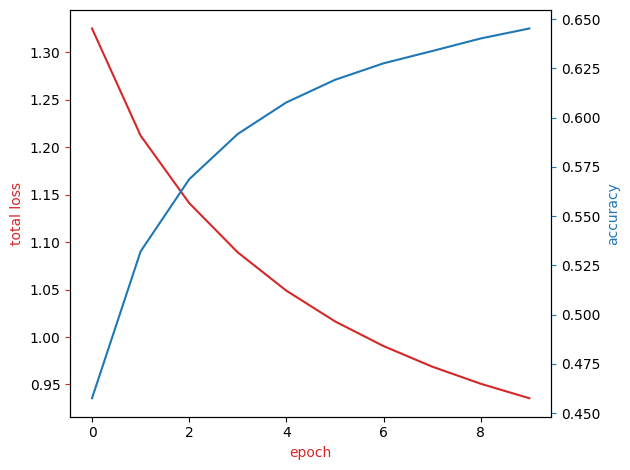

In [63]:
plot(cum_loss_list,acc_epoch)

In [64]:
evaluate(test_dataloader)

0.6598684210526315